In [2]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [5]:
data = pd.read_csv('..\..\..\listings.csv') #Importing Dataset
        
data_Numeric = pd.DataFrame(data[["id","host_total_listings_count","zipcode","latitude","longitude","accommodates","bathrooms","bedrooms","beds","price","weekly_price","monthly_price","security_deposit","cleaning_fee","guests_included","extra_people","minimum_nights","maximum_nights","availability_30","availability_90","availability_365","number_of_reviews","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","reviews_per_month"]])

for var in data_Numeric:
    if(data_Numeric[var].dtypes == "object"):
        data_Numeric[var] = data_Numeric[var].str.replace(',', '').str.replace('$', '')
        data_Numeric[var] = data_Numeric[var].apply(pd.to_numeric,errors='coerce')


data_Numeric = data_Numeric.dropna()
data_Numeric.info()
useless = ["zipcode","latitude","longitude"]
data_Numeric_changed=data_Numeric.drop(axis=1,columns=useless)

price_changed = pd.DataFrame(data_Numeric_changed["price"])
reviewscore_changed = pd.DataFrame(data_Numeric_changed["review_scores_rating"])





<class 'pandas.core.frame.DataFrame'>
Int64Index: 710 entries, 1 to 3810
Data columns (total 30 columns):
id                             710 non-null int64
host_total_listings_count      710 non-null float64
zipcode                        710 non-null float64
latitude                       710 non-null float64
longitude                      710 non-null float64
accommodates                   710 non-null int64
bathrooms                      710 non-null float64
bedrooms                       710 non-null float64
beds                           710 non-null float64
price                          710 non-null float64
weekly_price                   710 non-null float64
monthly_price                  710 non-null float64
security_deposit               710 non-null float64
cleaning_fee                   710 non-null float64
guests_included                710 non-null int64
extra_people                   710 non-null float64
minimum_nights                 710 non-null int64
maximum_nights    

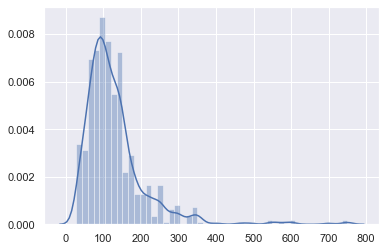

In [41]:
sb.distplot(price_changed)

In [42]:
from sklearn.model_selection import train_test_split

data_Numeric_Train, data_Numeric_test,price_Train, price_test,reviewscore_Train, reviewscore_test = train_test_split(data_Numeric_changed,price_changed,reviewscore_changed,test_size = 0.4)

print("Train Set :", data_Numeric_Train.shape, price_Train.shape, reviewscore_Train.shape)
print("Test Set  :", data_Numeric_test.shape, price_test.shape, reviewscore_test.shape)

Train Set : (426, 27) (426, 1) (426, 1)
Test Set  : (284, 27) (284, 1) (284, 1)


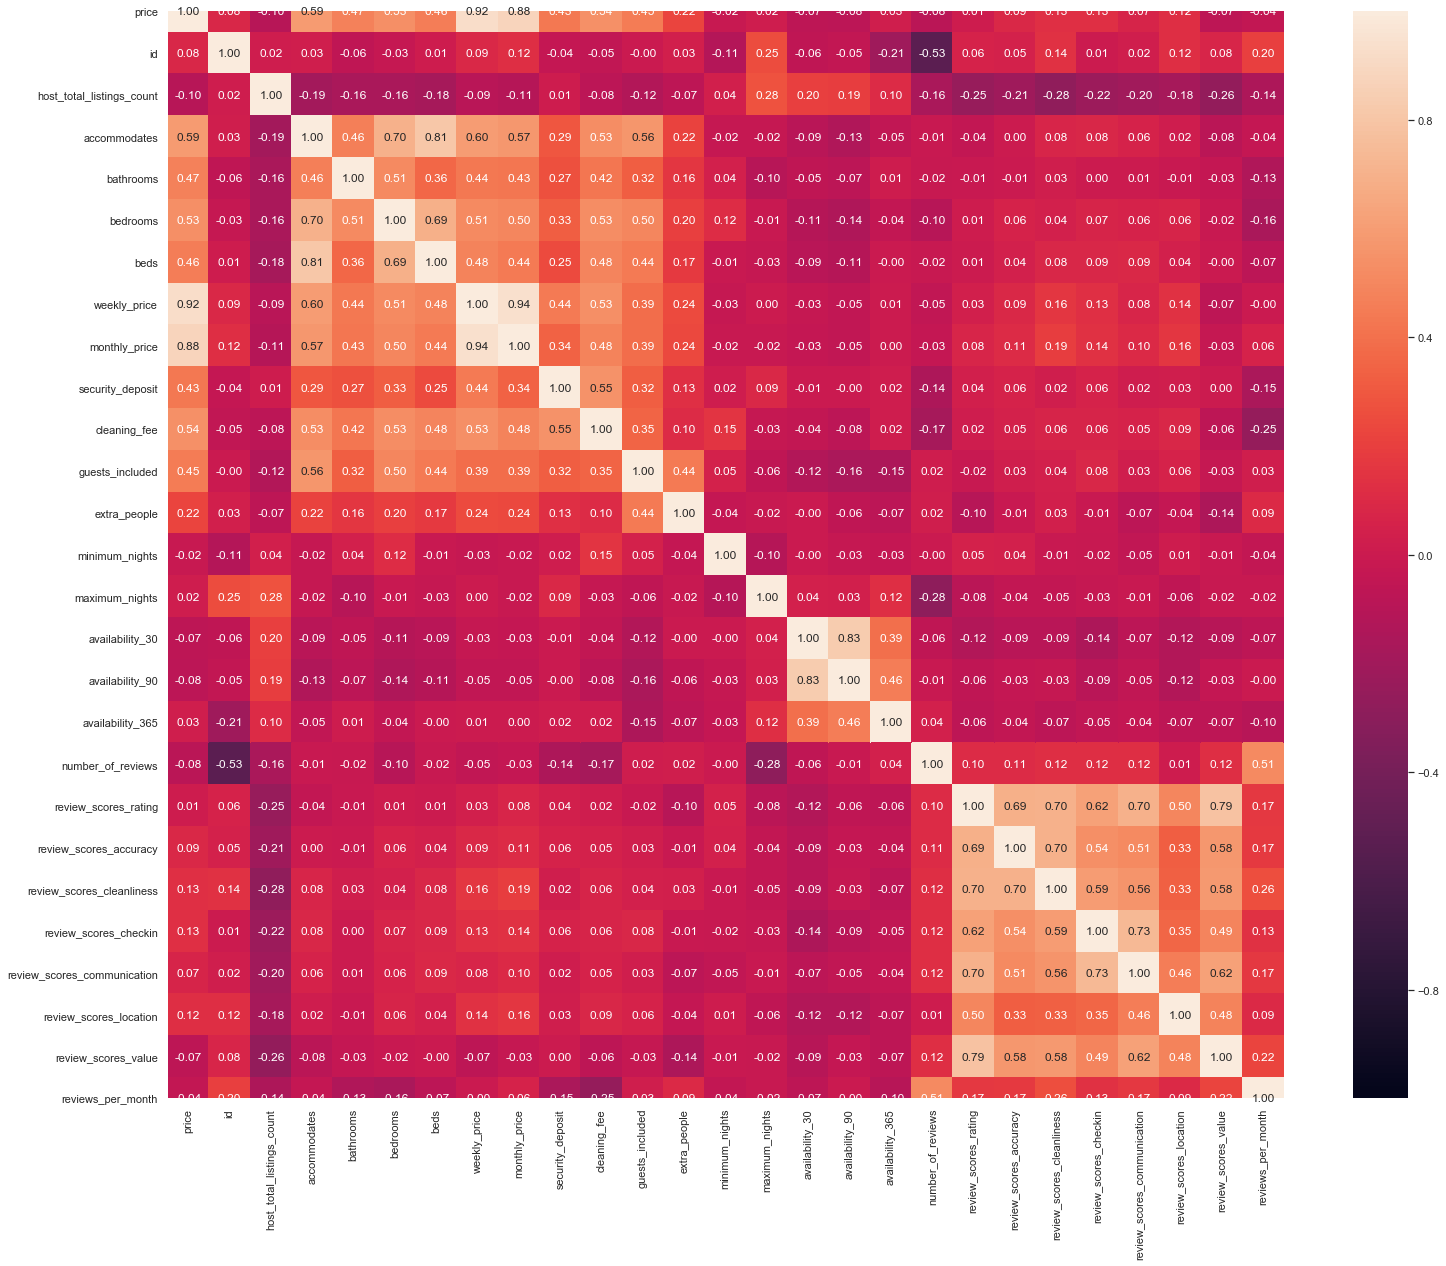

In [43]:
# Correlation between Response and the Predictors
trainDF = pd.concat([price_Train, data_Numeric_Train.reindex(index=data_Numeric_Train.index)], sort = False)

f, axes = plt.subplots(1, 1, figsize=(25, 20))
sb.heatmap(trainDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

In [44]:
count = 0
highrelation = []
for var in trainDF.corr():
    if(trainDF.corr()['price'][count] > 0.5):
        print("Variables that are Highly Related:",var)
        if(var != "price"):
            highrelation.append(var) 
    count+=1
    
index = 0
index2 = 0
Multi_High_Related_Train = {} 
Multi_High_Related_Test = {}

for var in highrelation:
    if(index < len(highrelation)):
        Multi_High_Related_Train[index]={} 
        Multi_High_Related_Test[index]={} 
        index+=1
        
index = 0
for var in highrelation:
    for var2 in highrelation:        
        if(var2 != var and index<len(highrelation)):
            Multi_High_Related_Train[index][index2] = pd.DataFrame(data_Numeric_Train[[var,var2]])
            Multi_High_Related_Test[index][index2] = pd.DataFrame(data_Numeric_test[[var,var2]])
            index2+=1
    index2=0
    index+=1



Variables that are Highly Related: price
Variables that are Highly Related: accommodates
Variables that are Highly Related: bedrooms
Variables that are Highly Related: weekly_price
Variables that are Highly Related: monthly_price
Variables that are Highly Related: cleaning_fee


In [45]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


index = 0
linreg = {}

for var in Multi_High_Related_Train:
    if(index < len(Multi_High_Related_Train)):
        linreg[index]={} 
        index+=1
        
index = 0
index2 = 0
for var in Multi_High_Related_Train:
    for var2 in Multi_High_Related_Train[var]:
        linreg[index][index2] = LinearRegression()
        linreg[index][index2].fit(Multi_High_Related_Train[index][index2], price_Train)
        index2+=1
    index2=0
    index+=1

In [46]:
index = 0
price_train_pred = {}
price_test_pred = {}

for var in linreg:
    if(index < len(linreg)):
        price_train_pred[index]={} 
        price_test_pred[index]={} 
        index+=1

index = 0
index2 = 0
for var in linreg:
    for var2 in linreg[var]:
        price_train_pred[index][index2] = linreg[index][index2].predict(Multi_High_Related_Train[index][index2])
        price_test_pred[index][index2] = linreg[index][index2].predict(Multi_High_Related_Test[index][index2])
        index2+=1
    index2=0
    index+=1

In [47]:
index = 0
index2 = 0

# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error


for var in price_train_pred:
    for var2 in price_train_pred[var]:
        if(linreg[index][index2].score(Multi_High_Related_Train[index][index2], price_Train)>0.3):
            print("For [",var,"][",var2,"]")
            print(Multi_High_Related_Train[index][index2].columns)
            print("Train Explained Variance (R^2) \t:", linreg[index][index2].score(Multi_High_Related_Train[index][index2], price_Train))
            print("Test Explained Variance (R^2) \t:", linreg[index][index2].score(Multi_High_Related_Test[index][index2], price_test))
            print()
        
        index2+=1
    index2=0
    index+=1

For [ 0 ][ 0 ]
Index(['accommodates', 'bedrooms'], dtype='object')
Train Explained Variance (R^2) 	: 0.37822074270937533
Test Explained Variance (R^2) 	: 0.48861256878626813

For [ 0 ][ 1 ]
Index(['accommodates', 'weekly_price'], dtype='object')
Train Explained Variance (R^2) 	: 0.8545214036779536
Test Explained Variance (R^2) 	: 0.8703209822699309

For [ 0 ][ 2 ]
Index(['accommodates', 'monthly_price'], dtype='object')
Train Explained Variance (R^2) 	: 0.784795044692439
Test Explained Variance (R^2) 	: 0.8258281022597507

For [ 0 ][ 3 ]
Index(['accommodates', 'cleaning_fee'], dtype='object')
Train Explained Variance (R^2) 	: 0.4238528582019312
Test Explained Variance (R^2) 	: 0.5356979384696858

For [ 1 ][ 0 ]
Index(['bedrooms', 'accommodates'], dtype='object')
Train Explained Variance (R^2) 	: 0.37822074270937533
Test Explained Variance (R^2) 	: 0.4886125687862682

For [ 1 ][ 1 ]
Index(['bedrooms', 'weekly_price'], dtype='object')
Train Explained Variance (R^2) 	: 0.8572463006662819


In [48]:
#try predicting

try_Pred = data_Numeric_changed[data_Numeric_changed["id"].isin(["4454295"])]
data_Numeric_changed.head()

,id,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
1,953595,6.0,4,1.0,1.0,1.0,150.0,1000.0,3000.0,100.0,...,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1.48
9,2493658,6.0,4,1.0,1.0,1.0,150.0,1000.0,3000.0,100.0,...,324,32,97.0,10.0,10.0,10.0,10.0,10.0,9.0,1.55
11,4454295,1.0,2,1.0,1.0,1.0,99.0,800.0,2000.0,500.0,...,229,8,97.0,10.0,10.0,9.0,10.0,10.0,9.0,0.98
12,3883392,1.0,4,1.0,2.0,3.0,245.0,1575.0,5800.0,300.0,...,362,13,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0.92
32,5978498,1.0,4,3.0,3.0,2.0,175.0,699.0,2388.0,200.0,...,213,8,88.0,9.0,9.0,9.0,9.0,10.0,9.0,1.31


In [49]:
data_needed = pd.DataFrame(try_Pred[Multi_High_Related_Train[0][3].columns])
prediction = linreg[0][3].predict(data_needed)
print("Predicted:",prediction)
print("Actual:", try_Pred['price'])

Predicted: [[144.35672983]]
Actual: 11    99.0
Name: price, dtype: float64


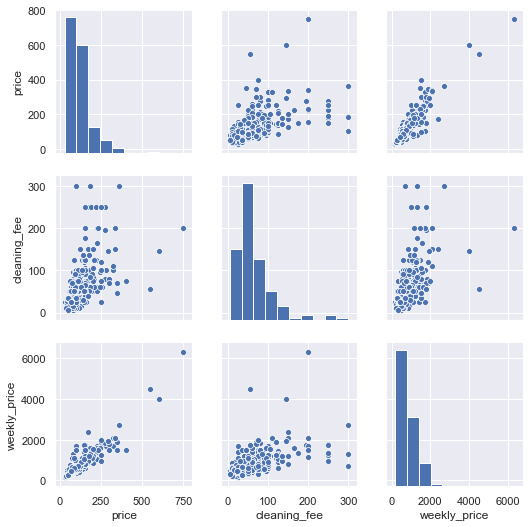

In [51]:

Multi_trainDF = pd.concat([price_Train, Multi_High_Related_Train[4][2].reindex(index=price_Train.index)], sort = False, axis = 1)
sb.pairplot(data = Multi_trainDF)

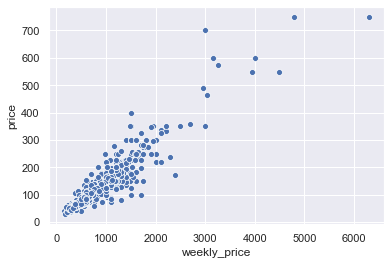

In [57]:
sb.scatterplot(x=data_Numeric_changed['weekly_price'],y=price_changed['price'])